In [3]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display
import matplotlib.pyplot as plt

/home/boston/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [5]:
def draw(image):
    plt.imshow(Image.fromarray(image))

In [6]:
mtcnn = MTCNN(keep_all=True, device=device)


In [7]:
video = mmcv.VideoReader('long.mp4')
frames = [(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]



In [8]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    frame=cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    # Detect faces
    
    
    boxes, _ = mtcnn.detect(frame)
    frame=Image.fromarray(frame)
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 450
Done


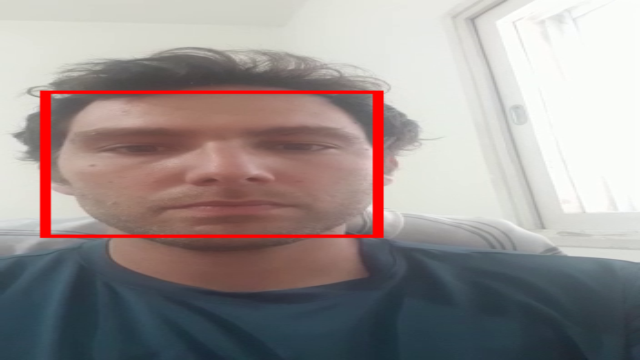

In [9]:

d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [93]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

In [23]:
def get_skin_image(image):
    lower = np.array([0, 53, 98])
    upper = np.array([26, 112, 225])

    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    skinMask = cv2.inRange(converted, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    skinMask = cv2.erode(skinMask, kernel, iterations=2)
    skinMask = cv2.dilate(skinMask, kernel, iterations=2)
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
    skinImg = cv2.bitwise_and(image, image, mask=skinMask)

    return skinImg, skinMask

In [26]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    frame=cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    # Detect faces
    
    
    boxes, _ = mtcnn.detect(frame)
    box=boxes[0]
    box=[int(round(abs(value))) for value in box]
    face=frame[box[1]:box[3],box[0]:box[2]]
    masked_face, skinMask = get_skin_image(face)
    cv2.imshow("video", masked_face)
    cv2.waitKey(1)
    masked_face=Image.fromarray(masked_face)
    frames_tracked.append(masked_face.resize((640, 360), Image.BILINEAR))

    
print('\nDone')

Tracking frame: 450
Done


In [28]:
face.shape

(270, 190, 3)

In [27]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('skin.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

In [24]:
frames_tracked[0].size

IndexError: list index out of range